In [1]:
import os
import numpy as np
import random as  rnd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
# set random seed
rnd.seed(32)

In [2]:
dirname = './'
filename = 'shakespeare_data.txt'
lines = [] # storing all the lines in a variable.

counter = 0

with open(os.path.join(dirname, filename)) as files:
    for line in files:
        # remove leading and trailing whitespace
        pure_line = line.strip().lower()

        # if pure_line is not empty string
        if pure_line:
            lines.append(pure_line)

n_lines = len(lines)
print(f"Number of lines: {n_lines}")

Number of lines: 125097


In [3]:
print("\n".join(lines[510:513]))

which, as he breathed defiance to my ears,
he swung about his head and cut the winds,
who nothing hurt withal hiss'd him in scorn:


In [4]:
text = "\n".join(lines)
# The unique characters in the file
vocab = sorted(set(text))
vocab.insert(0,"[UNK]") # Add a special character for any unknown
vocab.insert(1,"") # Add the empty character for padding.

print(f'{len(vocab)} unique characters')
print(" ".join(vocab))

56 unique characters
[UNK]  	 
   ! $ & ' ( ) , - . 0 1 2 3 4 5 6 7 8 9 : ; ? [ ] a b c d e f g h i j k l m n o p q r s t u v w x y z |


In [5]:
# an example to explain unicode_split
# it splits the string to characters
line = "Hello world!"
chars = tf.strings.unicode_split(line, input_encoding='UTF-8')
print(chars)

tf.Tensor([b'H' b'e' b'l' b'l' b'o' b' ' b'w' b'o' b'r' b'l' b'd' b'!'], shape=(12,), dtype=string)


In [6]:
# converts tensor of characters to ids
ids = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)(chars)
print(ids)

tf.Tensor([ 0 33 40 40 43  4 51 43 46 40 32  5], shape=(12,), dtype=int64)


In [7]:
def line_to_tensor(line, vocab):

    "this function converts string to tensor of numbers"

    # Split the input line into individual characters
    chars = tf.strings.unicode_split(line, input_encoding='UTF-8')

    # Map characters to their respective integer values using StringLookup
    ids = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)(chars)

    return ids

In [8]:
tmp_ids = line_to_tensor('abc xyz', vocab)
print(f"Result: {tmp_ids}")
print(f"Output type: {type(tmp_ids)}")

Result: [29 30 31  4 52 53 54]
Output type: <class 'tensorflow.python.framework.ops.EagerTensor'>


In [9]:
def text_from_ids(ids, vocab):

    "Converts a tensor of integer values into human-readable text."

    # Initialize the StringLookup layer to map integer IDs back to characters
    chars_from_ids = tf.keras.layers.StringLookup(vocabulary=vocab, invert=True, mask_token=None)

    # Use the layer to decode the tensor of IDs into string
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [10]:
text_from_ids(ids, vocab).numpy()

b'[UNK]ello world!'

In [11]:
train_lines = lines[:-1000]
eval_lines = lines[-1000:]

print(f"Number of training lines: {len(train_lines)}")
print(f"Number of validation lines: {len(eval_lines)}")

Number of training lines: 124097
Number of validation lines: 1000


In [12]:
all_ids = line_to_tensor("\n".join(["Hello world!", "Generative AI"]), vocab)
all_ids.numpy()

array([ 0, 33, 40, 40, 43,  4, 51, 43, 46, 40, 32,  5,  3,  0, 33, 42, 33,
       46, 29, 48, 37, 50, 33,  4,  0,  0])

In [13]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)
[text_from_ids([ids], vocab).numpy() for ids in ids_dataset.take(10)]

[b'[UNK]', b'e', b'l', b'l', b'o', b' ', b'w', b'o', b'r', b'l']

In [14]:
seq_length = 10
# drop_remainder used to drop the last tensor if it doesn't fit the vector dimension
# we will know why +1 later
data_generator = ids_dataset.batch(seq_length + 1, drop_remainder = True)

In [15]:
list(data_generator)

[<tf.Tensor: shape=(11,), dtype=int64, numpy=array([ 0, 33, 40, 40, 43,  4, 51, 43, 46, 40, 32])>,
 <tf.Tensor: shape=(11,), dtype=int64, numpy=array([ 5,  3,  0, 33, 42, 33, 46, 29, 48, 37, 50])>]

In [16]:
i = 1
for seq in data_generator.take(2):
    print(f"{i}. {text_from_ids(seq, vocab).numpy()}")
    i = i + 1

1. b'[UNK]ello world'
2. b'!\n[UNK]enerativ'


In [17]:
def split_input_target(sequence):

    "Splits the input sequence into two sequences, where one is shifted by one position."

    # Create the input sequence by excluding the last character
    input_text = sequence[:-1]
    # Create the target sequence by excluding the first character
    target_text = sequence[1:]

    return input_text, target_text

In [18]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [19]:
def create_batch_dataset(lines, vocab, seq_length = 100, batch_size = 64):

    "Creates a batch dataset from a list of text lines."

    BUFFER_SIZE = 10000

    # just join all lines into a single line
    single_line_data  = "\n".join(lines)

    # Convert data into a tensor
    all_ids = line_to_tensor(single_line_data, vocab)
    # Create a TensorFlow dataset from the data tensor
    ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

    # why +1 is necessary? if we have seq with len 10 we need to split it as input and output like 0:8 and 1:9
    # so we need an extra characteror the in/out len of seq will be -1
    data_generator = ids_dataset.batch(seq_length + 1, drop_remainder=True)
    # Map each input sample using the split_input_target function
    dataset_xy = data_generator.map(split_input_target)

    # Assemble the final dataset with shuffling, batching, and prefetching
    dataset = (dataset_xy.shuffle(BUFFER_SIZE).batch(batch_size, drop_remainder=True))

    return dataset

In [20]:
tf.random.set_seed(1)
dataset = create_batch_dataset(train_lines, vocab, seq_length=16, batch_size=2)

print("Prints the elements into a single batch. The batch contains 2 elements: ")

for input_example, target_example in dataset.take(1):
    print(text_from_ids(input_example[0], vocab).numpy())
    print(text_from_ids(target_example[0], vocab).numpy())

    print(text_from_ids(input_example[1], vocab).numpy())
    print(text_from_ids(target_example[1], vocab).numpy())

Prints the elements into a single batch. The batch contains 2 elements: 
b'ot\nin these conf'
b't\nin these confu'
b"s'd,\nto mangle m"
b"'d,\nto mangle me"


In [21]:
BATCH_SIZE = 64
dataset = create_batch_dataset(train_lines, vocab, seq_length=100, batch_size = BATCH_SIZE)

In [22]:
class GRULM(tf.keras.Model):

    def __init__(self, vocab_size=256, embedding_dim=256, rnn_units=128):
        super().__init__()

        # Create an embedding layer to map token indices to embedding vectors
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)
        # Define a GRU layer for sequence modeling
        self.gru = tf.keras.layers.GRU(rnn_units, return_sequences=True, return_state=True)
        # Apply a dense layer with log-softmax activation to predict next tokens
        self.dense = tf.keras.layers.Dense(vocab_size, activation=tf.nn.log_softmax)

    def call(self, inputs, states=None, return_state=False, training=False):

        x = inputs

        # Map input tokens to embedding vectors
        x = self.embedding(x, training=training)

        x, states = self.gru(x, initial_state=states, training=training)

        # Predict the next tokens and apply log-softmax activation
        x = self.dense(x, training = training)

        if return_state:
            return x, states

        else:
            return x



In [23]:
vocab_size = 82

# The embedding dimension
embedding_dim = 256

# RNN layers
rnn_units = 512

model = GRULM(
    vocab_size = vocab_size,
    embedding_dim = embedding_dim,
    rnn_units = rnn_units)

In [24]:
# model.build(input_shape=(BATCH_SIZE, 100))
model.call(Input(shape=(100,)))
model.summary()

Model: "grulm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 256)            │          20,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ [(None, 100, 512), (None,   │       1,182,720 │
│                                      │ 512)]                       │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100, 82)             │          42,066 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,245,778 (4.75 MB)

 Trainable params: 1,245,778 (4.75 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
def compile_model(model):

    "Sets the loss and optimizer for the given model"

    # Define the loss function
    # we set from_logits to True because the model produces log probabilities which is not directly proba
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

    # Define the optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.0125)

    # Compile the model
    model.compile(optimizer = opt, loss = loss)

    return model

In [26]:
EPOCHS = 2

model = compile_model(model)

history = model.fit(dataset, epochs = EPOCHS)

Epoch 1/2
790/790 ━━━━━━━━━━━━━━━━━━━━ 1196s 2s/step - loss: 2.4939
Epoch 2/2
790/790 ━━━━━━━━━━━━━━━━━━━━ 1218s 2s/step - loss: 1.9699


In [27]:
output_dir = 'model.weights.h5'

try:
   os.path.exists(output_dir)
   print("Directory exists")
except:
   os.path.mkdir(output_dir)
   print("Directory created")

model.save_weights(output_dir)

Directory exists


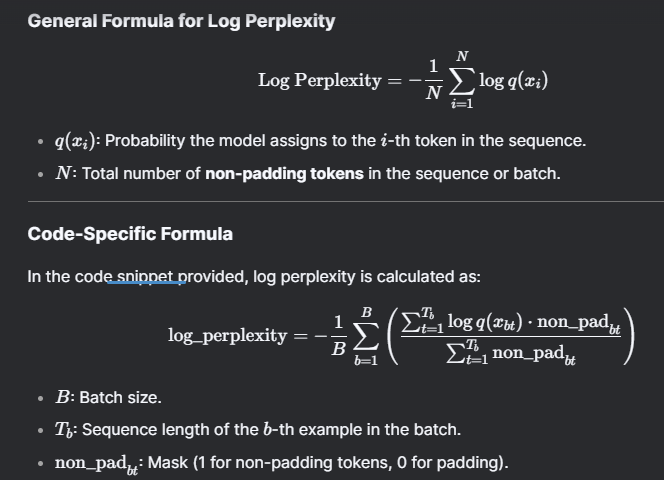

In [28]:
def log_perplexity(preds, target):

    "Function to calculate the log perplexity of a model"

    PADDING_ID = 1

    # Calculate log probabilities for predictions using one-hot encoding
    log_p = np.sum(tf.one_hot(target, depth=preds.shape[-1]) * preds, axis= -1)

    # Identifies padding positions (1 for padding, 0 otherwise) then (1.0-)invert it (1 for non-padding, 0 for padding)
    non_pad = 1.0 - np.equal(target, PADDING_ID)

    # Apply non-padding mask to log probabilities to exclude padding
    log_p = log_p * non_pad

    # Calculate the log perplexity by taking the sum of log probabilities and dividing by the sum of non-padding elements
    log_ppx = np.sum(log_p, axis= -1) / np.sum(non_pad, axis=-1)

    # Compute the mean of log perplexity
    log_ppx = np.mean(log_ppx)

    return -log_ppx

In [29]:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 512

model = GRULM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units = rnn_units)

# model.build(input_shape=(100, vocab_size))

model.load_weights('model.weights.h5')

In [30]:
eval_text = "\n".join(eval_lines)
eval_ids = line_to_tensor([eval_text], vocab)
input_ids, target_ids = split_input_target(tf.squeeze(eval_ids, axis = 0))

preds, status = model(tf.expand_dims(input_ids, 0),
                      training=False, states=None,
                      return_state=True)

#Get the log perplexity
log_ppx = log_perplexity(preds, tf.expand_dims(target_ids, 0))
print(f'log perplexity: {log_ppx}')

log perplexity: 4.025095951886058


In [31]:
def temperature_random_sampling(log_probs, temperature = 1.0):

    """
    The higher the temperature, the more random the output.
    If temperature is close to 0, it means that the model
    will just return the index of the character with the highest input log_score
    """

   # Generate uniform random numbers with a slight offset to avoid log(0)
    u = tf.random.uniform(minval = 1e-6, maxval = 1.0 - 1e-6, shape = log_probs.shape)

    # Apply the Gumbel distribution transformation for randomness
    g = -tf.math.log(-tf.math.log(u))

    # Adjust the logits with the temperature and choose the character with the highest score
    return tf.math.argmax(log_probs + g * temperature, axis = -1)

In [32]:
class GenerativeModel(tf.keras.Model):
    def __init__(self, model, vocab, temperature=1.0):

        "A generative model for text generation."

        super().__init__()

        self.temperature = temperature
        self.model = model
        self.vocab = vocab

    @tf.function
    def generate_one_step(self, inputs, states = None):

        "Generate a single character and update the model state."

        # Transform the inputs into tensors
        input_ids = line_to_tensor(inputs, self.vocab)

        # Ensure the tensor is dense
        input_ids = input_ids.to_tensor()

        # Predict the sequence for the given input_ids. Use the states and return_state=True
        predicted_logits, states = self.model(input_ids, states, return_state = True)

        # Get only last element of the sequence, the last hidden state hold the represetation for the sequence
        predicted_logits = predicted_logits[0, -1, :]

        # Use the temperature_random_sampling to generate the next character
        predicted_ids = temperature_random_sampling(predicted_logits, self.temperature)

        # Use the chars_from_ids to transform the id into the corresponding char
        predicted_chars = text_from_ids([predicted_ids], self.vocab)

        # Return the characters and model state.
        return tf.expand_dims(predicted_chars, 0), states

    def generate_n_chars(self, num_chars, prefix):

        "Generate a text sequence of a specified length, starting with a given prefix."

        states = None
        next_char = tf.constant([prefix])
        result = [next_char]

        for n in range(num_chars):
            next_char, states = self.generate_one_step(next_char, states = states)
            result.append(next_char)

        return tf.strings.join(result)[0].numpy().decode('utf-8')

In [35]:
tf.random.set_seed(272)
gen = GenerativeModel(model, vocab, temperature = 0.5)

print(gen.generate_n_chars(32, " "), '\n\n' + '_'*80)
print(gen.generate_n_chars(32, "Dear"), '\n\n' + '_'*80)
print(gen.generate_n_chars(32, "KING"), '\n\n' + '_'*80)

 &&0
2gbwc']-nc)vd6)(x0?n-|rw7e[UNK]m 

________________________________________________________________________________
Dear0spwt:	?z ]x]n[cz08 v[r-&fe;:q-& 

________________________________________________________________________________
KING
:'j[UNK]oa;e
2.70io$sy)[UNK]?2!:l!(gee? 

________________________________________________________________________________
